## Graph 1 --> Single Input

Graph (The Complete workflow structure) -->  State (data shared across the workflow) --> Nodes (Steps that mopdify the state)  --> Edges (connections between nodes)

In [1]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph # frame that helps you design and mange the flow of tasks in your application using a graph 

In [2]:
# We now create an Agentstate- shared data structure that keeps track of infomation as your application runs
# state Schema
class AgentState(TypedDict):
    message : str

def greeting_node(state: AgentState):
    """Simple node that adds a greeting message to the state"""

    state["message"] = "Hey " + state["message"] + " , how is your day going?"
    return state


In [3]:
graph = StateGraph(AgentState)
graph.add_node("greeter", greeting_node)

graph.set_entry_point("greeter")
graph.set_finish_point("greeter")

app =graph.compile()

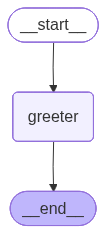

In [4]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [5]:
result = app.invoke({"message": "Bob"})
result["message"]

'Hey Bob , how is your day going?'

## Graph 2 -->  multiple inputs

In [6]:
from typing import Dict, TypedDict, List
from langgraph.graph import StateGraph 


In [7]:
class AgentState(TypedDict):
    name : str
    values: List[int]
    result : str

def process_values_node(state: AgentState):
    """This function accepts multiple values from the state and processes them"""
    state["result"] = f"Hi there {state['name']}, the sum of your values is {sum(state['values'])}"
    return state
 


In [8]:
graph_2 = StateGraph(AgentState)
graph_2.add_node("processor", process_values_node)  
graph_2.set_entry_point("processor")
graph_2.set_finish_point("processor") 
app_2 = graph_2.compile()


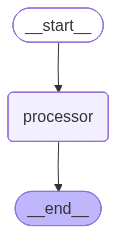

In [9]:
from langgraph.graph import StateGraph
from IPython.display import display, Image  
display(Image(app_2.get_graph().draw_mermaid_png()))

In [10]:
aapp_result = app_2.invoke({"name": "Alice", "values": [10, 20, 30]})
aapp_result["result"]

'Hi there Alice, the sum of your values is 60'

## Graph 3 --> Sequential Graphs with multiple nodes

In [11]:
from typing import  TypedDict, List
from langgraph.graph import StateGraph
class AgentState(TypedDict):
    name : str
    age: int  
    result : str


def first_node(state: AgentState):
    """This first node creates a greeting message based on name"""
    state["result"] = f"Hello {state['name']}"
    return state
def second_node(state: AgentState):
    """This second node appends age information to the greeting message"""
    state["result"] += f", you are {state['age']} years old."
    return state


In [12]:
graph = StateGraph(AgentState)
graph.add_node("first_node", first_node)
graph.add_node("second_node", second_node)
graph.add_edge("first_node", "second_node")
graph.set_entry_point("first_node")
graph.set_finish_point("second_node")  

app = graph.compile()

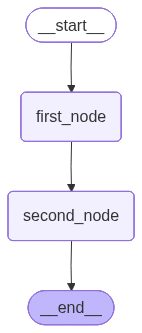

In [13]:
from IPython.display import display, Image  
display(Image(app.get_graph().draw_mermaid_png()))

In [14]:
app_result = app.invoke({"name": "Charlie", "age": 28})
app_result["result"]

'Hello Charlie, you are 28 years old.'

## Graph 4 - Conditional Graphs

In [18]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph, START, END # frame that helps you design and mange the flow of tasks in your application using a graph

class AgentState(TypedDict):
    a : int
    b : int
    result : int
    operation : str

def add_node(state: AgentState):
    """Node that adds two numbers from the state"""
    state["result"] = state["a"] + state["b"]
    return state

def multiply_node(state: AgentState):
    """Node that multiplies two numbers from the state"""
    state["result"] = state["a"] * state["b"]
    return state

def decide_node_next(state: AgentState):
    """Node that decides which operation to perform based on the state"""
    if state["operation"] == "add":
        return "add_node" # r
    elif state["operation"] == "multiply":
        return "multiply_node"


In [38]:
graph = StateGraph(AgentState)
graph.add_node("add_node", add_node)
graph.add_node("multiply_node", multiply_node)
graph.add_node("decide_node", lambda state: state) # passthrough node for decision making

graph.add_edge(START, "decide_node")

graph.add_conditional_edges(
    "decide_node",
    decide_node_next, # path decion node
    {
        # Edge: Node
        "add_node": "add_node",
        "multiply_node": "multiply_node"
    }
)

graph.add_edge("add_node", END)
graph.add_edge("multiply_node", END)

app = graph.compile()


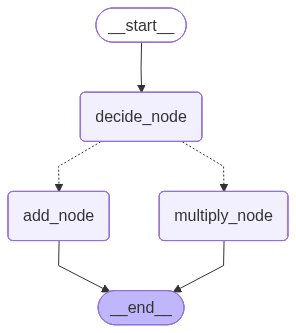

In [39]:
from IPython.display import display, Image  
display(Image(app.get_graph().draw_mermaid_png()))

In [40]:
intial_state = AgentState(a=5, b=3, operation="multiply")
print(app.invoke(intial_state)["result"])  # Outputs: 15

15


## Graph 5 --> Looping Graph

### Objective : 
1. Implement looping logic to route the flow of data back to the nodes.
2. Create a single condtional edge to handle decision-making and control graph flow.

In [57]:
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image
from typing import TypedDict, List, Dict



In [58]:
class AgentState(TypedDict):
    name : str
    number: List[int]
    counter: int

In [65]:
def greeting_node(state: AgentState):
    """Simple node that adds a greeting message to the state"""
    state["name"] = f" hello, {state['name']}"
    state["counter"] = 0
    return state

def random_node(state: AgentState):
    """Node that appends a random number to the state's number list and increments counter"""
    import random
    state["number"].append(random.randint(1, 100))
    state["counter"] += 1
    return state

def check_counter_next(state: AgentState):
    """Decides whether to continue adding random numbers or finish based on counter"""
    if state["counter"] < 5:
        return "loop" # continue adding numbers
    else:
        return "exit" # finish process



In [66]:
# greeting --> random --> random --> random --> end_node

In [67]:
graph = StateGraph(AgentState)
graph.add_node("greeting", greeting_node)
graph.add_node("random_node", random_node)
graph.add_edge("greeting", "random_node")

graph.add_conditional_edges(
    "random_node",
    check_counter_next,
    {
        "loop": "random_node",  # loop back to random_node
        "exit": END
    }
)

graph.add_edge(START, "greeting")

app = graph.compile()

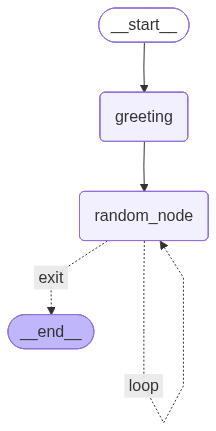

In [68]:
display(Image(app.get_graph().draw_mermaid_png()))

In [69]:
app_result = app.invoke({"name": "Diana", "number": [], "counter": 0})
app_result  # List of 5 random numbers added

{'name': ' hello, Diana', 'number': [81, 67, 83, 19, 72], 'counter': 5}